In [1]:
# !pip install opencv-python
# !pip install glob2
# !pip install seaborn
# !pip install opencv-contrib-python-headless
# !pip install scikit-image
# !pip install scikit-learn
# !pip install tabulate

In [2]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pretrained_models.inceptionv3net import InceptionV3Net
from pretrained_models.vgg16net import VGG16Net
from pretrained_models.xceptionnet import XceptionNet
from pretrained_models.resnet50net import ResNet50Net
from pypackage.classifier import Classifier
from pypackage.preprocessor import Preprocessor
from pypackage.feature_extractor import FeatureExtractor
import tensorflow as tf

2023-02-04 12:53:02.271839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and Resize data

In [3]:
# Read input images and assign labels based on folder names
SIZE1 = 224  # Resize images
SIZE2 = 299  # Resize images

In [4]:
# Capture training data and labels into respective lists
train_images = []
train_labels = []
i = 0
for directory_path in glob.glob("../datasets/Training/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, 
                 cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE1, SIZE1))
        train_images.append(img)
        train_labels.append(label)
        
        i += 1
        if i == 10:
            i = 0
            break
        

# Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[10 10 10 10]


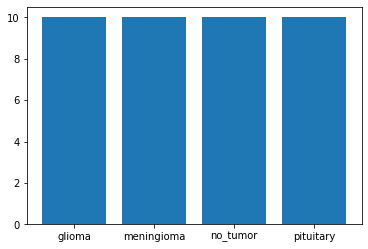

In [5]:
classes, counts = np.unique(train_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes))
print(classes)
print(counts)

In [6]:
# Capture test/validation data and labels into respective lists
test_images = []
test_labels = []
i = 0
for directory_path in glob.glob("../datasets/Testing/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE1, SIZE1))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)
        
        i += 1
        if i == 4:
            i = 0
            break

# Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[4 4 4 4]


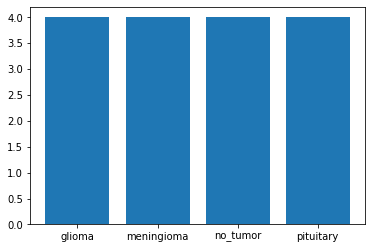

In [7]:
classes, counts = np.unique(test_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes))
print(classes)
print(counts)

### Data Augmentation

#### Train dataset

In [8]:
# flip left-right direction
da_train_images = np.append( train_images, [ np.fliplr(x) for x in train_images], axis=0 )
da_train_labels = np.append( train_labels, [ x for x in train_labels] )

# flip up-down direction
da_train_images = np.append( da_train_images, [ np.flipud(x) for x in train_images], axis=0 )
da_train_labels = np.append( da_train_labels, [ x for x in train_labels] )

# add salt and pepper noise
da_train_images = np.append( da_train_images, [ Preprocessor.addNoise(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)) for x in train_images], axis=0 )
da_train_labels = np.append( da_train_labels, [ x for x in train_labels] )

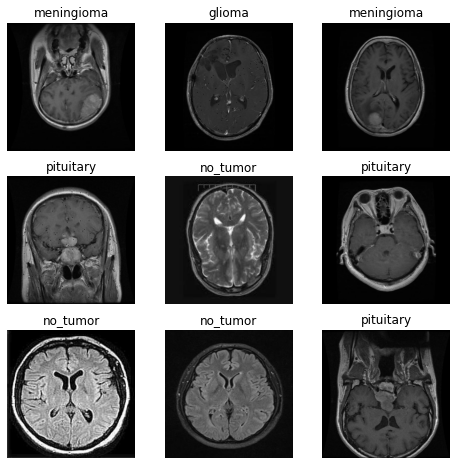

In [9]:
plt.figure(figsize=(8, 8))
for i, idx in enumerate(np.random.randint(da_train_images.shape[0], size=9), start=1):
    plt.subplot(3, 3, i)
    plt.imshow( da_train_images[idx], cmap='gray')
    plt.title(str(da_train_labels[idx]))
    plt.axis('off')

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[40 40 40 40]


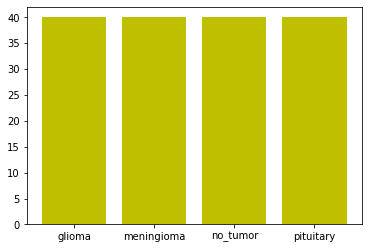

In [10]:
classes, counts = np.unique(da_train_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes),
        width = 0.8, color = ['y'])
print(classes)
print(counts)

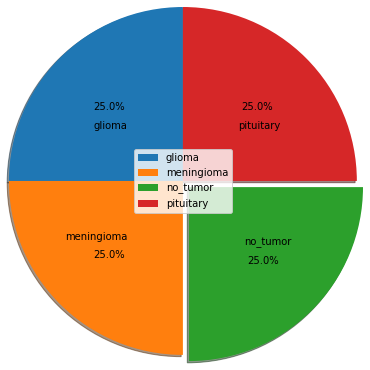

In [11]:
# color for each label
colors = ['r', 'y', 'g', 'b']
plt.pie(counts, labels = classes, labeldistance=0.45,
        startangle=90, shadow = True, explode = (0, 0, 0.1, 0),
        radius = 2, autopct = '%1.1f%%')
  
# plotting legend
plt.legend(loc='center')
  
# showing the plot
plt.show()

#### Test dataset

In [12]:
# flip left-right direction
da_test_images = np.append( test_images, [ np.fliplr(x) for x in test_images], axis=0 )
da_test_labels = np.append( test_labels, [ x for x in test_labels] )

# flip up-down direction
da_test_images = np.append( da_test_images, [ np.flipud(x) for x in test_images], axis=0 )
da_test_labels = np.append( da_test_labels, [ x for x in test_labels] )

# add salt and pepper noise
da_test_images = np.append( da_test_images, [ Preprocessor.addNoise(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)) for x in test_images], axis=0 )
da_test_labels = np.append( da_test_labels, [ x for x in test_labels] )

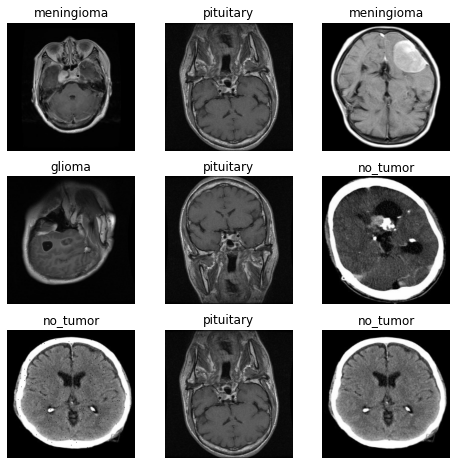

In [13]:
plt.figure(figsize=(8, 8))
for i, idx in enumerate(np.random.randint(da_test_images.shape[0], size=9), start=1):
    plt.subplot(3, 3, i)
    plt.imshow( da_test_images[idx], cmap='gray')
    plt.title(str(da_test_labels[idx]))
    plt.axis('off')

['glioma' 'meningioma' 'no_tumor' 'pituitary']
[16 16 16 16]


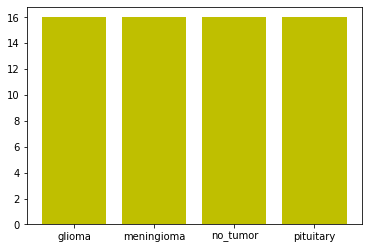

In [14]:
classes, counts = np.unique(da_test_labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(classes),
        width = 0.8, color = ['y'])
print(classes)
print(counts)

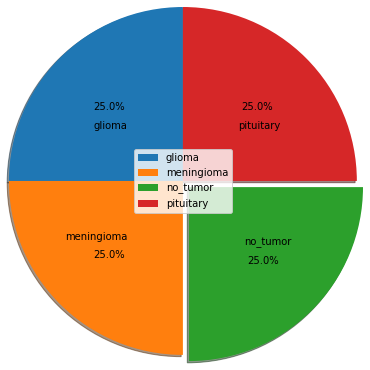

In [15]:
# color for each label
colors = ['r', 'y', 'g', 'b']
plt.pie(counts, labels = classes, labeldistance=0.45,
        startangle=90, shadow = True, explode = (0, 0, 0.1, 0),
        radius = 2, autopct = '%1.1f%%')
  
# plotting legend
plt.legend(loc='center')
  
# showing the plot
plt.show()

### Encode labels

In [16]:
# Encode labels from text to integers.
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(da_test_labels)
test_labels_encoded = le.transform(da_test_labels)
le.fit(da_train_labels)
train_labels_encoded = le.transform(da_train_labels)

In [17]:
# Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = (
    da_train_images,
    train_labels_encoded,
    da_test_images,
    test_labels_encoded,
)

In [18]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [19]:
# One hot encode y values for neural network.
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

### Load model, preprocess input and extract features

#### VGG16

In [20]:
# Load model without classifier/fully connected layers
vgg_model = VGG16Net.build(SIZE1)

2023-02-04 12:53:15.277042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
# preprocess the train input
vgg_x_train = VGG16Net.preprocess(x_train)
vgg_x_train.shape

(160, 224, 224, 3)

In [22]:
# Now, let us use features from convolutional network
vgg_train_ft = FeatureExtractor.extract(vgg_model, vgg_x_train)

5/5 [==============================] - 47s 10s/step


In [23]:
# preprocess the train input
vgg_x_test = VGG16Net.preprocess(x_test)

In [24]:
# Send test data through same feature extractor process
vgg_test_ft = FeatureExtractor.extract(vgg_model, vgg_x_test)

2/2 [==============================] - 18s 10s/step


#### ResNet50

In [25]:
# Load model without classifier/fully connected layers
resnet_model = ResNet50Net.build(SIZE1)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [26]:
# preprocess the train input
resnet_x_train = ResNet50Net.preprocess(x_train)
resnet_x_train.shape

(160, 224, 224, 3)

In [27]:
# Now, let us use features from convolutional network
resnet_train_ft = FeatureExtractor.extract(resnet_model, resnet_x_train)

5/5 [==============================] - 20s 3s/step


In [28]:
# preprocess the train input
resnet_x_test = ResNet50Net.preprocess(x_test)

In [29]:
# Send test data through same feature extractor process
resnet_test_ft = FeatureExtractor.extract(resnet_model, resnet_x_test)

2/2 [==============================] - 7s 3s/step


#### InceptionV3

In [30]:
# Load model without classifier/fully connected layers
inception_model = InceptionV3Net.build(SIZE1)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [31]:
# preprocess the train input
# inception_x_train = tf.image.resize(x_train,[299,299])
inception_x_train = InceptionV3Net.preprocess(x_train)
inception_x_train.shape

(160, 224, 224, 3)

In [32]:
# Now, let us use features from convolutional network
inception_train_ft = FeatureExtractor.extract(inception_model, inception_x_train)

5/5 [==============================] - 12s 2s/step


In [33]:
# preprocess the test input
# inception_x_test = tf.image.resize(x_test,[299,299])
inception_x_test = InceptionV3Net.preprocess(x_test)

In [34]:
# Send test data through same feature extractor process
inception_test_ft = FeatureExtractor.extract(inception_model, inception_x_test)

2/2 [==============================] - 4s 2s/step


#### Xception

In [35]:
# Load model without classifier/fully connected layers
xception_model = XceptionNet.build(SIZE1)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [36]:
# preprocess the train input
# xception_x_train = tf.image.resize(x_train,[299,299])
xception_x_train = XceptionNet.preprocess(x_train)
xception_x_train.shape

(160, 224, 224, 3)

In [37]:
# Now, let us use features from convolutional network
xception_train_ft = FeatureExtractor.extract(xception_model, xception_x_train)

5/5 [==============================] - 19s 4s/step


In [38]:
# preprocess the test input
# xception_x_test = tf.image.resize(x_test,[299,299])
xception_x_test = XceptionNet.preprocess(x_test)

In [39]:
# Send test data through same feature extractor process
xception_test_ft = FeatureExtractor.extract(xception_model, xception_x_test)

2/2 [==============================] - 7s 3s/step


### Feature Fusion

In [40]:
train_ft = np.concatenate([xception_train_ft, inception_train_ft, resnet_train_ft, vgg_train_ft], 1)

In [41]:
test_ft = np.concatenate([xception_test_ft, inception_test_ft, resnet_test_ft, vgg_test_ft], 1)

In [42]:
train_ft.shape

(160, 276992)

In [43]:
test_ft.shape

(64, 276992)

### Random Forest classifier

In [44]:
# Prediction from Random Forest classifier
pred_RF = Classifier.RF(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_RF = le.inverse_transform(pred_RF)

# Print accuracy, precision, fscore
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score

test_labels = da_test_labels
RF_Accuracy = accuracy_score(test_labels, pred_RF)
RF_Precision = precision_score(test_labels, pred_RF, average='weighted')
RF_Fscore = f1_score(test_labels, pred_RF, average='weighted')

print("RF_Accuracy = ", RF_Accuracy, "RF_Precision = ", RF_Precision, "RF_Fscore = ", RF_Fscore)

RF_Accuracy =  0.515625 RF_Precision =  0.5055555555555555 RF_Fscore =  0.49784946236559147


[[ 5 11  0  0]
 [ 0  4 12  0]
 [ 4  0  8  4]
 [ 0  0  0 16]]


<AxesSubplot:>

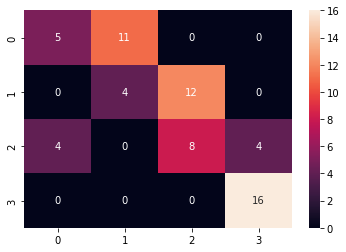

In [45]:
# Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, pred_RF)
print(cm)
sns.heatmap(cm, annot=True)

### Naive Bayes classifier

In [46]:
# Prediction from Naive Bayes classifier
pred_NB = Classifier.NB(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_NB = le.inverse_transform(pred_NB)

# Print accuracy, precision, fscore

NB_Accuracy = accuracy_score(test_labels, pred_NB)
NB_Precision = precision_score(test_labels, pred_NB, average='weighted')
NB_Fscore = f1_score(test_labels, pred_NB, average='weighted')

print("NB_Accuracy = ", NB_Accuracy, "NB_Precision = ", NB_Precision, "NB_Fscore = ", NB_Fscore)

NB_Accuracy =  0.40625 NB_Precision =  0.40555555555555556 NB_Fscore =  0.3861150070126227


[[ 5  9  0  2]
 [ 0  0 16  0]
 [ 4  0 10  2]
 [ 0  1  4 11]]


<AxesSubplot:>

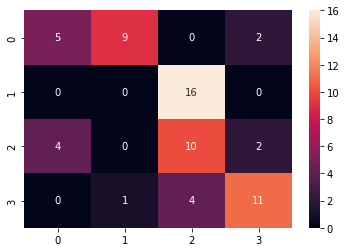

In [47]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_NB)
print(cm)
sns.heatmap(cm, annot=True)

### Logistic Regression classifier

In [48]:
# Prediction from Logistic Regression classifier
pred_LR = Classifier.LR(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_LR = le.inverse_transform(pred_LR)

# Print accuracy, precision, fscore

LR_Accuracy = accuracy_score(test_labels, pred_LR)
LR_Precision = precision_score(test_labels, pred_LR, average='weighted')
LR_Fscore = f1_score(test_labels, pred_LR, average='weighted')

print("LR_Accuracy = ", LR_Accuracy, "LR_Precision = ", LR_Precision, "LR_Fscore = ", LR_Fscore)

LR_Accuracy =  0.421875 LR_Precision =  0.4589646464646465 LR_Fscore =  0.43194383016364446


/Users/oluwasetty/.virtualenvs/dis_lpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 5 11  0  0]
 [ 0  4 12  0]
 [ 6  0  8  2]
 [ 1  3  2 10]]


<AxesSubplot:>

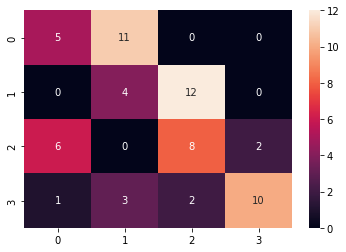

In [49]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_LR)
print(cm)
sns.heatmap(cm, annot=True)

### K Nearest Neighbors classifier

In [50]:
# Prediction from K Nearest Neighbors classifier
pred_KNN = Classifier.KNN(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_KNN = le.inverse_transform(pred_KNN)

# Print accuracy, precision, fscore

KNN_Accuracy = accuracy_score(test_labels, pred_KNN)
KNN_Precision = precision_score(test_labels, pred_KNN, average='weighted')
KNN_Fscore = f1_score(test_labels, pred_KNN, average='weighted')

print("KNN_Accuracy = ", KNN_Accuracy, "KNN_Precision = ", KNN_Precision, "KNN_Fscore = ", KNN_Fscore)

KNN_Accuracy =  0.421875 KNN_Precision =  0.4810876623376623 KNN_Fscore =  0.428874269005848


[[ 8  8  0  0]
 [ 0  4 12  0]
 [ 7  0  8  1]
 [ 5  2  2  7]]


<AxesSubplot:>

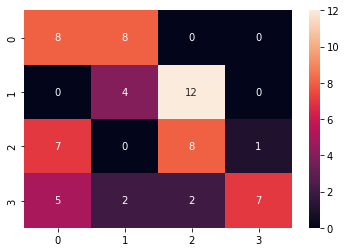

In [51]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_KNN)
print(cm)
sns.heatmap(cm, annot=True)

### Decision Tree classifier

In [52]:
# Prediction from Decision Tree classifier
pred_DT = Classifier.DT(train_ft, test_ft, y_train)

# Inverse le transform to get original label back.
pred_DT = le.inverse_transform(pred_DT)

# Print accuracy, precision, fscore

DT_Accuracy = accuracy_score(test_labels, pred_DT)
DT_Precision = precision_score(test_labels, pred_DT, average='weighted')
DT_Fscore = f1_score(test_labels, pred_DT, average='weighted')

print("DT_Accuracy = ", DT_Accuracy, "DT_Precision = ", DT_Precision, "DT_Fscore = ", DT_Fscore)

DT_Accuracy =  0.5 DT_Precision =  0.5829545454545455 DT_Fscore =  0.5220760233918129


[[ 6 10  0  0]
 [ 0  4 12  0]
 [ 2  6  8  0]
 [ 0  2  0 14]]


<AxesSubplot:>

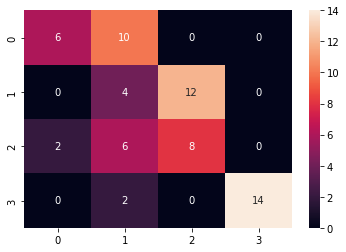

In [53]:
# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, pred_DT)
print(cm)
sns.heatmap(cm, annot=True)

### Performance Metrics

In [54]:
from tabulate import tabulate

In [55]:
# create data
data = [
    ["RF", RF_Accuracy, RF_Precision, RF_Fscore],
    ["NB", NB_Accuracy, NB_Precision, NB_Fscore],
    ["LR", LR_Accuracy, LR_Precision, LR_Fscore],
    ["DT", DT_Accuracy, DT_Precision, DT_Fscore],
    ["KNN", KNN_Accuracy, KNN_Precision, KNN_Fscore],
]

# define header names
col_names = ["Classifier", "Accuracy", "Precision", "F1-score"]

# display table
print(tabulate(data, headers=col_names, tablefmt="rounded_grid"))

Classifier      Accuracy    Precision    F1-score
------------  ----------  -----------  ----------
RF              0.515625     0.505556    0.497849
NB              0.40625      0.405556    0.386115
LR              0.421875     0.458965    0.431944
DT              0.5          0.582955    0.522076
KNN             0.421875     0.481088    0.428874


In [56]:
# np.save("Extracted features/inceptiontrain", train_ft)

In [57]:
# np.save("Extracted features/inceptiontest", test_ft)